# 作業 : (Kaggle)房價預測

# [作業目標]
- 試著模仿範例寫法, 在房價預測中, 觀察去除離群值的影響

# [作業重點]
- 觀察將極端值以上下限值取代, 對於分布與迴歸分數的影響 (In[5], Out[5])
- 觀察將極端值資料直接刪除, 對於分布與迴歸分數的影響 (In[6], Out[6])

In [1]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

data_path = '../data/'
df_train = pd.read_csv(data_path + 'house_train.csv.gz')

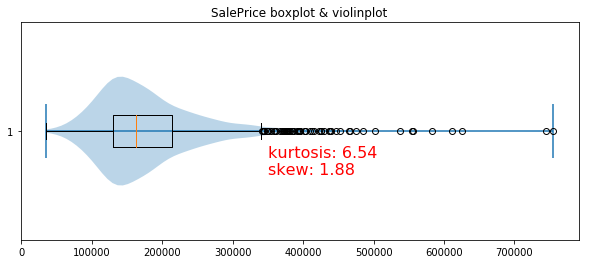

In [2]:
#From boxplot of feature SalePrice that there's a right skewness or positive skewness.
plt.figure(figsize=(10, 4))
plt.boxplot(df_train.SalePrice, vert=False)
plt.violinplot(df_train.SalePrice, vert=False)
plt.title('SalePrice boxplot & violinplot')
plt.text(350000, 0.8, 'kurtosis: {:.3} \nskew: {:.3}'.format(df_train.SalePrice.kurtosis(), df_train.SalePrice.skew()),
         {'color':'r', 'size':16});

In [3]:
# Apply log(1 + x) to reduce skew of SalePrice.
train_Y = np.log1p(df_train['SalePrice']) 
df = df_train.drop(['Id', 'SalePrice'] , axis=1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [4]:
#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
print(f'{len(num_features)} Numeric Features : {num_features}\n')

36 Numeric Features : ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']



In [5]:
# 削減文字型欄位, 只剩數值型欄位
df = df[num_features]
df = df.fillna(-1)
MMEncoder = MinMaxScaler()
train_num = train_Y.shape[0]
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,548,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,460,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,608,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,642,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,836,192,84,0,0,0,0,0,12,2008


# 作業1
* 試著限制 '1樓地板面積(平方英尺)' (1stFlrSF) 欄位的上下限, 看看能否再進一步提高分數?

C:\Users\crea\Anaconda3\envs\my_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


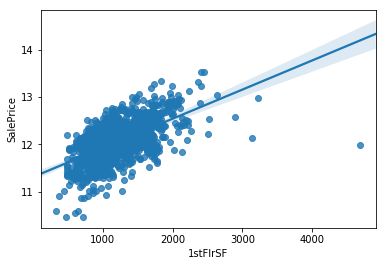

C:\Users\crea\Anaconda3\envs\my_env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


0.8499683837163878

In [6]:
# 顯示 1stFlrSF 與目標值的散佈圖
import seaborn as sns
import matplotlib.pyplot as plt
sns.regplot(x = df['1stFlrSF'][:train_num], y=train_Y)
plt.show()

# 做線性迴歸, 觀察分數
train_X = MMEncoder.fit_transform(df)
estimator = LinearRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

C:\Users\crea\Anaconda3\envs\my_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


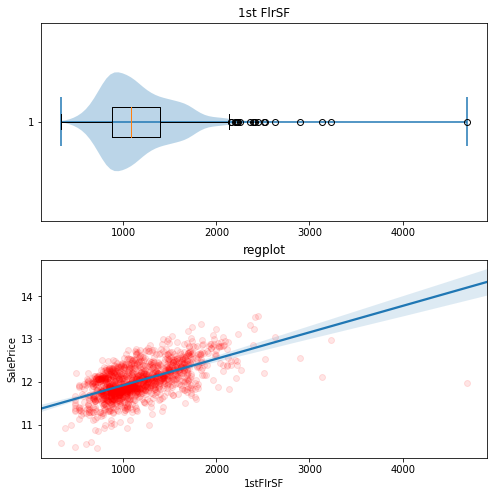

In [7]:
plt.figure(figsize=(8, 8))
plt.subplot(211)
plt.title('1st FlrSF')
plt.boxplot(df['1stFlrSF'], vert=False)
plt.violinplot(df['1stFlrSF'], vert=False);
plt.subplot(212)
plt.title('regplot')
sns.regplot(df['1stFlrSF'], train_Y, scatter_kws={'alpha':0.1, 'color':'r'});

In [8]:
critical_point = 2000 
result = {}
df_1 = df.copy()
for i in range(10):
    df_1['1stFlrSF'] = df['1stFlrSF'].clip(upper=critical_point)
    train_X = MMEncoder.fit_transform(df_1)
    result[critical_point] = cross_val_score(estimator, train_X, train_Y, cv=5).mean()
    critical_point += 100

C:\Users\crea\Anaconda3\envs\my_env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\crea\Anaconda3\envs\my_env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\crea\Anaconda3\envs\my_env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\crea\Anaconda3\envs\my_env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\crea\Anaconda3\envs\my_env\lib\site-packages\sklearn\preprocessing\data.py:323:

In [9]:
result

{2000: 0.877930959951194,
 2100: 0.8813628040774631,
 2200: 0.8840091206088184,
 2300: 0.886760801855235,
 2400: 0.8884280153375907,
 2500: 0.8886877546783781,
 2600: 0.8881727656527099,
 2700: 0.8854454711972346,
 2800: 0.8779201914844892,
 2900: 0.8630102988871728}

In [10]:
clip_result = pd.DataFrame(result, index=[0])
clip_result

,2000,2100,2200,2300,2400,2500,2600,2700,2800,2900
0,0.877931,0.881363,0.884009,0.886761,0.888428,0.888688,0.888173,0.885445,0.87792,0.86301


In [11]:
# 將 1stFlrSF 限制在你覺得適合的範圍內, 調整離群值
"""
Your Code Here
"""
df_1 = df.copy()
df_1['1stFlrSF'] = df['1stFlrSF'].clip(upper=2500)
# 做線性迴歸, 觀察分數
train_X = MMEncoder.fit_transform(df_1)
estimator = LinearRegression()
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

C:\Users\crea\Anaconda3\envs\my_env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


0.8886877546783781

C:\Users\crea\Anaconda3\envs\my_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


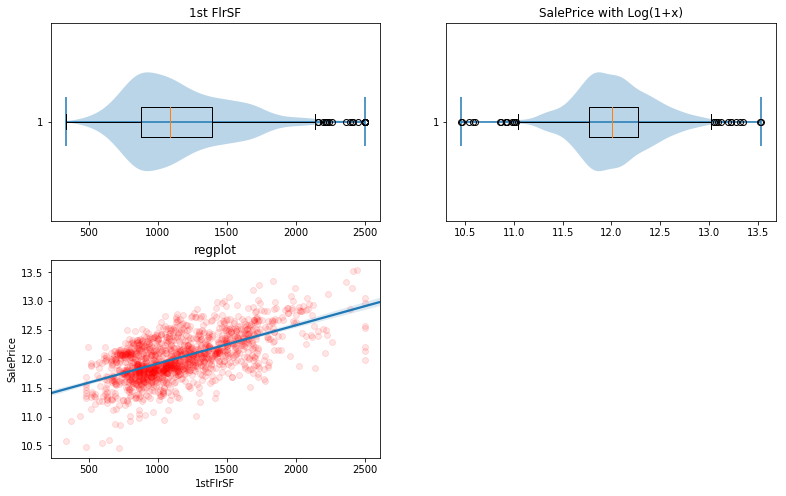

In [12]:
plt.figure(figsize=(13, 8))
plt.subplot(221)
plt.title('1st FlrSF')
plt.boxplot(df_1['1stFlrSF'], vert=False)
plt.violinplot(df_1['1stFlrSF'], vert=False);
plt.subplot(222)
plt.title('SalePrice with Log(1+x)')
plt.boxplot(train_Y, vert=False)
plt.violinplot(train_Y, vert=False)
plt.subplot(223)
plt.title('regplot')
sns.regplot(df_1['1stFlrSF'], train_Y, scatter_kws={'alpha':0.1, 'color':'r'});

# 作業2
* 續前題, 去除離群值有兩類方式 :  捨棄離群值(刪除離群的資料) 以及調整離群值,  
請試著用同樣的上下限, 改為 '捨棄離群值' 的方法, 看看結果會變好還是變差? 並試著解釋原因。  
Ans: 從summary結果可看到skip_outlier比clip_outlier的效果來的好。  
推測原因如下:  
1.主要是針對測試集進行回歸測試進行判斷，捨棄資料的方式可能會失去其他重要特徵因而對預測的測試集有影響。  
2.拿掉outlier的數據，對同一訓練數據集模型的擬合程度是定性的增加，但取代的方式未省略資料量還保留其他特徵影響模型的擬合程度以及本身取代outlier的數值也會影響模型不容易掌握。
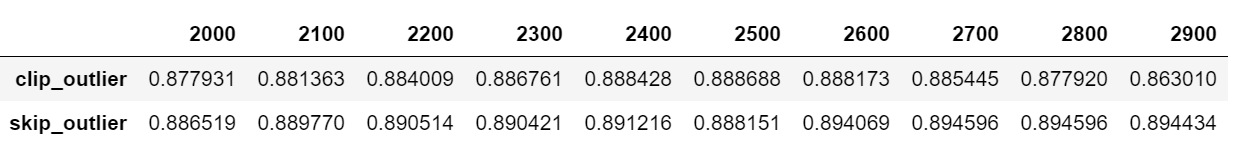

In [13]:
critical_point = 2000 
result_1 = {}
for i in range(10):
    keep_index = df['1stFlrSF'] < critical_point
    df_2 = df[keep_index]
    train_Y_2 = train_Y[keep_index]
    train_X_2 = MMEncoder.fit_transform(df_2)
    result_1[critical_point] = cross_val_score(estimator, train_X_2, train_Y_2, cv=5).mean()
    critical_point += 100

C:\Users\crea\Anaconda3\envs\my_env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\crea\Anaconda3\envs\my_env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\crea\Anaconda3\envs\my_env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\crea\Anaconda3\envs\my_env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\crea\Anaconda3\envs\my_env\lib\site-packages\sklearn\preprocessing\data.py:323:

In [14]:
result_1

{2000: 0.8865190130498404,
 2100: 0.8897704556752821,
 2200: 0.8905141487279737,
 2300: 0.8904213287358361,
 2400: 0.8912159305539081,
 2500: 0.8881505826584585,
 2600: 0.894068734577494,
 2700: 0.8945958706794755,
 2800: 0.8945958706794755,
 2900: 0.8944340780940679}

In [15]:
skip_result = pd.DataFrame(result_1, index=[0])
skip_result

,2000,2100,2200,2300,2400,2500,2600,2700,2800,2900
0,0.886519,0.88977,0.890514,0.890421,0.891216,0.888151,0.894069,0.894596,0.894596,0.894434


In [16]:
# 將 1stFlrSF 限制在你覺得適合的範圍內, 捨棄離群值
"""
Your Code Here
"""
keep_index = df['1stFlrSF'] < 2500
df_2 = df[keep_index]
train_Y_2 = train_Y[keep_index]
# 做線性迴歸, 觀察分數
train_X = MMEncoder.fit_transform(df_2)
estimator = LinearRegression()
cross_val_score(estimator, train_X, train_Y_2, cv=5).mean()

C:\Users\crea\Anaconda3\envs\my_env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


0.8881505826584585

C:\Users\crea\Anaconda3\envs\my_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


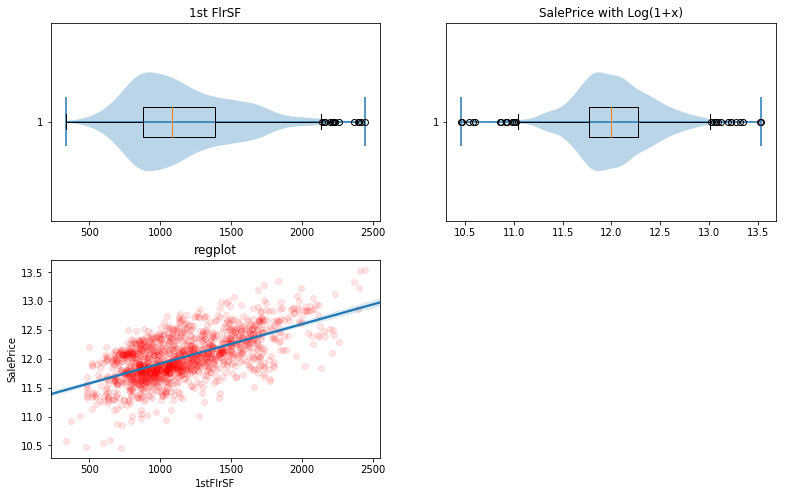

In [17]:
plt.figure(figsize=(13, 8))
plt.subplot(221)
plt.title('1st FlrSF')
plt.boxplot(df_2['1stFlrSF'], vert=False)
plt.violinplot(df_2['1stFlrSF'], vert=False);
plt.subplot(222)
plt.title('SalePrice with Log(1+x)')
plt.boxplot(train_Y_2, vert=False)
plt.violinplot(train_Y_2, vert=False)
plt.subplot(223)
plt.title('regplot')
sns.regplot(df_2['1stFlrSF'], train_Y_2, scatter_kws={'alpha':0.1, 'color':'r'});

In [18]:
summary = pd.concat([clip_result, skip_result], ignore_index=True)
summary.index = ['clip_outlier', 'skip_outlier']

In [19]:
summary

,2000,2100,2200,2300,2400,2500,2600,2700,2800,2900
clip_outlier,0.877931,0.881363,0.884009,0.886761,0.888428,0.888688,0.888173,0.885445,0.877920,0.863010
skip_outlier,0.886519,0.889770,0.890514,0.890421,0.891216,0.888151,0.894069,0.894596,0.894596,0.894434
